# Fondamenti di Fisica Computazionale

#### Raffaele Mura 70/89/00373

# Assignment 2.0 

### Equazione del calore

L'equazione del calore è un equazione parabolica paradigmatica, nella particolarità essa è in due variabili, una spaziale (consideriamo un sistema unidimensionale) e una coordinata temporale. 
La funzione incognità è la temperatura, in funzione quindi di $x$ e $t$.

Avremo: 

$ k{\delta^2 T \over \delta x^2}={\delta T \over \delta t}$

Il coefficiente k è detto diffusività termica $\big[{m^2\over s}\big]$ ed è legato alla conducibilità termica del materiale da un prefattore che dipende dal calore specifico del materiale e dalla densità del materiale stesso. 

In generale interpretando l'equazione possiamo verificare come la variazione positiva di temperatura in un determinato punto $x_0$ ad un determinato istante $t_0$ avviene in funzione della positivà del termine: $ {\delta^2 T \over \delta x^2}(x_0, t_0)$ cioè se in corrispondenza di quel determinato punto si ha una concavità verso l'alto, la temperatura conseguentemente ha una variazione positiva (e viceversa).

Più nella pratica, dato un sbarra di metallo con un profilo di temperatura iniziale dato, i punti in cui avremo una temperatura maggiore (punto di massimo) tendono a raffreddarsi, i punti invece in cui la temperatura è localmente inferiore tendono a riscaldarsi. 

Si studia quindi la soluzione numerica dell'equazione sopra riportata.

Si supponga un'equazione del calore in cui è dato il profilo di temperatura inziale, (funzione $\delta$) analiticamente ci si aspetta una soluzione del tipo:

$T(x,t)={1 \over \sqrt{s\pi} \sigma (t)}exp^{-{(x-x_0)^2 \over 2\sigma^2(t)}} $

Avremo quindi un primo effetto che descrive l'andamento della temperatura che descresce esponenzialmente dal suo valore di picco, e in secondo luogo avremo che il picco tende ad allargarsi nello spazio all'evolvere del tempo secondo $\sigma$. Dove $\sigma = \sqrt{2kt}$

In particolare per questo progetto è stato scelto un profilo di temperatura sinusoidale: <br>
$T(x,0)=T_0-A_0cos({2\pi x \over \lambda})$<br>
per un sistema unidimensionale di lunghezza $L=100 m$.<br>
Dove: <br>
- $T_0=300K$ è la temperatura media 
- $A_0=10k$ è l'ampiezza iniziale del profilo
- $\lambda={L\over 2}$ è la lunghezza d'onda del profilo di temperatura

<br>

Per poter procedere nello studio della soluzione numerica dell'equazione, la prima operazione da effettuare è quella di discretizzare il dominio. 

Si suddivide il dominio spaziale di lunghezza totale $l$ in $n+1$ intervalli di ampiezza $h={L\over N}$. <br> Avremo quindi una variabile $x_i= - {L\over 2}+hi$ dove $i=0,...,N$ <br>
Dopodichè si discretizza la variabile temporale, dove considereremo il tempo $t_n=t_0+n\tau$ dove $\tau$ è il time step scelto per la trattazione. 

Per conoscere quindi la temperatura in determinati $x$ e $t$ si utilizza il metodo *FTCS (Forward Time Centered Space)*. 

Quindi si utilizza l'espressione centered-difference per risolvere
la derivata spaziale seconda (variando l'indice di posizione e fissando l'indice temporale) e la forward-differecenze per quanto riguarda la derivata temporale prima (variando l'indice temporale e fissando l'indice spaziale), per aver quindi un'espressione finale della temperatura $n+1$ pari a: <br>
$T_i^{n+1}=T_i^n+{\tau k\over h^2}[T_{i+1}^n+t_{i-1}^n-2T_i^n]$
<br>
Quindi predice $T$ nel punto $i$ al tempo $n+1$ usando valori di $T$ al tempo $n$ nei punti $i,i+1,i-1$

Le condizioni al contorno dell'equazione, fondamentali per la risoluzione,  si definiscono imponendo il valore del profilo di temperatura iniziale per tutti i punti spaziali e inoltre imponendo che ai bordi il valore della temperatura sia fissato. 


Si considera infine una condizione sulla scelta dei valori caratteristici di $tau$ e $h$ che condiziona la stabilità.
C'è la presenza di un problema di stabilità perchè la funzione che descrive il profilo inziale si allarga con un tasso di velocità dipendente da $k$.
Bisogna scegliere un intervallo spaziale e temporale in maniera tale da descrivere idoneamente l'allargamento.

Il coefficiente dell'equazione ${\tau k\over h^2}$ lega fra loro i parametri $tau$ e $h$, questi sono scelti in maniera coesa. 
Ne risulta quindi un vincolo di stabilità che lega i parametri secondo la relazione: <br> $t_s={h^2\over 2k}$  dove per aver  una buona descrizione sia dell'evoluzione temporale che dell'evoluzione spaziale del profilo si dovrà scegliere un time step sempre minore uguale a $t_s$.
La condizione di stabilità si traduce in: $\tau \leq t_s={h^2\over 2k}$

Nella praticità con un valore di $h$ piccolo dovremo scegliere un $tau$ piccolo a parità di $k$, o nel caso di una diffusività termica molto grande, il profilo evolve temporalemtne molto velocemente e fa si che il $tau$ debba essere piccolo. 


In primo luogo siamo interessati a rappresentare graficamente l'evoluzione temporale del profilo imponendo le condizioni al contorno di Neumann.

Imponendo le condizioni dal contorno di Neumann imponiamo che il flusso di calore sia nullo ai bordi, ovvero la derivata prima della temperatura rispetto a $x$ nei punti $0$ ed $L$ dev'essere uguale a $0$ a tutti gli istanti. Significa quindi che avremo una temperatura che si distribuirà completamente all'interno del dominio, la temperatura raggiungera quindi, per tempi elevati, un valore costante. 



Una volta importate le librerie utili, e definite delle variabili quali:
- $N_x$ Numero di intervalli per cui dividiamo l'intera lunghezza del sistema unidimensionale
- $N_t$ Numero di step da compiere
- $h$ lunghezza dell'intervallo
<br> <br>definiamo un sistema di funzioni che implementano il metodo FTCS. <br><br>
La funzione *init* definisce $dt$ minore di $t_s$ e implementa il profilo di temperatura iniziale. <br>
La funzione *solve* chiamata da *init* itera la chiamata di *step* un numero di volte pari a $N_t$<br>
Infine la funzione *step* implementa il metodo di risoluzione come sopra definito utilizzando anche le condizioni al contorno di Neumann chiamando la funzione *Neumann_conditions*.

In [1]:
import scipy.optimize as spo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn')
N_x, N_t = 100, 10000
h = 1                                                      
T0=300
A0=10
Ti=np.zeros(N_x)


def Neumann_conditions(old_T, new_T):
    return new_T[1], new_T[-2]


def step(old_T, alpha, h, dt):
    N_x = len(old_T)
    new_T = np.zeros(N_x)
    
    for i in range(1, N_x - 1):
        new_T[i] = old_T[i] + (dt * alpha) / h**2 * (old_T[i+1] + old_T[i-1] - 2 * old_T[i])
    new_T[0], new_T[-1] = Neumann_conditions(old_T, new_T)
    return new_T


def solve(N_t, T, alpha, h, dt):
    
    for i in range(1, N_t):
        T[i] = step(T[i - 1], alpha, h, dt)
    return T


def init(alpha, lamb): 
    T1 = np.zeros((N_t, N_x))  
    dt = (0.1 * h**2) / (2 * alpha)                                                
 
    for i in range(N_x):
        Ti[i]=T0-A0*np.cos(2*np.pi*i/lamb)


    for i in range(N_x):
        T1[0][i] = Ti[i] 
    
    T = solve(N_t, T1, alpha, h, dt)
    return T,dt

T,dt=init(0.5,50)

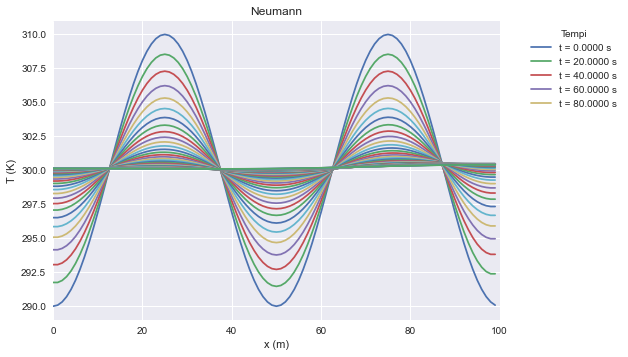

In [2]:
fig, ax = plt.subplots()
for i in range(0, N_t, int(N_t / 50)):
    
    if i==0 or i==200 or i==400 or i==600 or i==800:
        ax.plot([h * i for i in range(N_x)], T[i], label = "t = %1.4f s" % (i*dt))
    else: 
        ax.plot([h * i for i in range(N_x)], T[i])
    
ax.set_xlabel("x (m)")
ax.set_xlim(left=0, right=100)
ax.set_ylabel("T (K)")
ax.set_title("Neumann")
ax.legend(title='Tempi', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Il grafico sopra rappresenta quindi l'evoluzione temporale del profilo.<br>

<br>
Si vuole dimostrare ora che l'ampiezza del profilo sinusoidale descresce esponenzialmente nel tempo secondo la legge: <br>
$A(t)=A_0exp^{-t\over \tau}+c$<br>

Si definisce quindi la funzione *max_amplitude* che restituisce una lista dell'ampiezza massima del profilo per ogni time-step.
<br> Quindi si fittano i dati calcolati attaverso la funzione *curve_fit*, dal grafico sottostante essi risultano congruenti.  

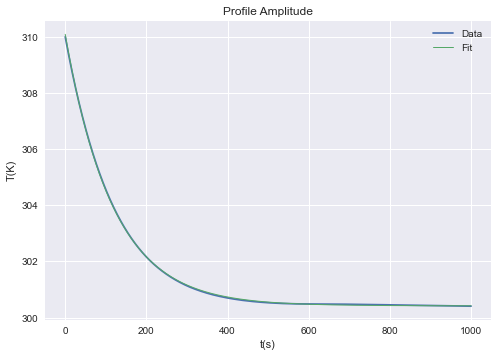

In [16]:
def max_amplitude(N_x, N_t, T):
    max_list=[]
    
    for i in range(N_t):
        
        max_value=np.max(T[i][:])
        max_list.append(max_value)
    return max_list

def fit(t,A0,dt,c):
    return A0*np.exp(-t/dt)+c

max_values=max_amplitude(N_x, N_t, T)
tmp=np.linspace(0,N_t*dt,N_t)

fig, ax = plt.subplots()
ax.plot(tmp,max_values, label="Data")
p,cov=spo.curve_fit(fit,tmp,max_values, p0=[10, 120, 300])
ax.plot(tmp,fit(tmp, p[0], p[1], p[2]), linewidth=1, label="Fit")
ax.set_ylabel("T(K)")
ax.set_xlabel("t(s)")
ax.set_title("Profile Amplitude")
#ax.set_xlim(left=0, right=10)
ax.legend()



Ora si dimostra che per delle diverse simulazioni sotto compiute il tempo di rilassamento $\tau$ è legato alla diffusività termica ($\alpha$), dalla seguente relazione approssimata: <br>
$\alpha \approx ({\lambda^2 \over 4\pi^2 \tau})$
<br>
Si effettuano quindi tre prime simulazioni variando il parametro della funzione *init* **alpha** e mantenendo fissato il paramento **lamb**.

In [4]:
T1,dt1=init(0.5, 50)
T2,dt2=init(5, 50)
T3,dt3=init(50, 50)

In [26]:
lamb=50
print("Primo confronto, lambda fissato 50 m")
tau=(lamb**2)/(4*np.pi**2*0.5)
tmp=np.linspace(0,N_t*dt1,N_t)
max_values1=max_amplitude(N_x, N_t, T1)
p,cov=spo.curve_fit(fit,tmp,max_values1, p0=[10, 120, 300])
print("Data :\n  tau:",tau, "s alpha:0.5 m^2/s")
print("Fit:\n  tau:",p[1], "s alpha:0.5 m^2/s", )

print("\nSecondo confronto, lambda fissato 50 m")
tau=lamb**2/(4*np.pi**2*5)
tmp=np.linspace(0,N_t*dt2,N_t)
max_values2=max_amplitude(N_x, N_t, T2)
p,cov=spo.curve_fit(fit,tmp,max_values2)
print("Data :\n  tau:",tau, "s alpha: 5 m^2/s" )
print("Fit:\n  tau:",p[1], "s alpha: 5 m^2/s")

print("\nTerzo confronto, lambda fissato 50 m")
tau=lamb**2/(4*np.pi**2*50)
max_values3=max_amplitude(N_x, N_t, T3)
tmp=np.linspace(0,N_t*dt3,N_t)
p,cov=spo.curve_fit(fit,tmp,max_values3, p0=[10, 1, 300])
print("Data :\n  tau:",tau, "s alpha:50 m^2/s$")
print("Fit:\n  tau:",p[1], "s alpha:50 m^2/s")



Primo confronto, lambda fissato 50 m
Data :
  tau: 126.65147955292223 s alpha:0.5 m^2/s
Fit:
  tau: 116.7997258153323 s alpha:0.5 m^2/s

Secondo confronto, lambda fissato 50 m
Data :
  tau: 12.665147955292221 s alpha: 5 m^2/s
Fit:
  tau: 11.67997262424027 s alpha: 5 m^2/s

Terzo confronto, lambda fissato 50 m
Data :
  tau: 1.2665147955292222 s alpha:50 m^2/s$
Fit:
  tau: 1.1679972586189116 s alpha:50 m^2/s


Si effettuano ora altre tre simulazioni variando il parametro della funzione *init* **lamb** e mantenendo fissato il paramento **alpha**.

In [30]:
T1,dt1=init(50, 100)
T2,dt2=init(50, 50)
T3,dt3=init(50, 25)

In [41]:
alpha=50
print("Primo confronto, alpha fissato 5 m^2/s")
tau=100**2/(4*np.pi**2*alpha)
max_values1=max_amplitude(N_x, N_t, T1)
tmp=np.linspace(0,N_t*dt1,N_t)
p,cov=spo.curve_fit(fit,tmp,max_values1, p0=[10, 5, 300])
print("Data :\n  tau:",tau, "s lambda:100 m")
print("Fit:\n  tau:",p[1], "s lambda:100 m" )


print("\nSecondo confronto, lambda fissato 50 m")
tau=50**2/(4*np.pi**2*alpha)
max_values2=max_amplitude(N_x, N_t, T2)
tmp=np.linspace(0,N_t*dt2,N_t)
p2,cov=spo.curve_fit(fit,tmp,max_values2, p0=[10, 1, 300])
print("Data :\n  tau:",tau, "s lambda:50 m" )
print("Fit:\n  tau:",p2[1], "s lambda:50 m")

print("\nTerzo confronto, lambda fissato 50 m")
tau=25**2/(4*np.pi**2*alpha)
max_values3=max_amplitude(N_x, N_t, T3)
tmp=np.linspace(0,N_t*dt3,N_t)
p3,cov=spo.curve_fit(fit,tmp,max_values3, p0=[10, 1, 300])
print("Data :\n  tau:",tau, "s lambda:25 m")
print("Fit:\n  tau:",p3[1], "s lambda:25 m")



Primo confronto, alpha fissato 5 m^2/s
Data :
  tau: 5.066059182116889 s lambda:100 m
Fit:
  tau: 4.944549424422035 s lambda:100 m

Secondo confronto, lambda fissato 50 m
Data :
  tau: 1.2665147955292222 s lambda:50 m
Fit:
  tau: 1.1679972586189116 s lambda:50 m

Terzo confronto, lambda fissato 50 m
Data :
  tau: 0.31662869888230555 s lambda:25 m
Fit:
  tau: 0.318588299774431 s lambda:25 m


Come si evince dai risultati delle varie simulazioni la relazione approssimata: $\alpha \approx ({\lambda^2 \over 4\pi^2 \tau})$ è sempre verificata, con uno scostamento fra i $\tau$ calcolati sempre inferiore al 10%.

# Assignment 2.1 

### Trasformata di Fourier


In generale una forma d'onda periodica può essere costruita come somma di $k$ onde armoniche semplici. La serie di Fourier $y(x)= \sum_{k=0}^n A_ksen(kx+\phi_k)$ può quindi descrivere una forma generica di onda periodica. 
Sviluppando l'espressione essa può essere ricondotta a: $f(x)={a_0 \over 2} + \sum_{K=1}^\infty (a_kcoskx+b_ksenkx)$ che mette in evidenza i coefficienti moltiplicativi delle varie armoniche semplici alle diverse frequenze.

Nell'interesse dello studio nel dominio della frequenza di una funzione non periodica, le espressioni sopra riportate non sono valide. Si utilizza quindi il concetto di trasformata di Fourier come operatore per esprimere la funzione nel dominio di $\omega$.
Data la non periodicità il periodo della funzione verrà consideranto come tendente all'infinito, applicando quindi gli stessi concetti utilizzati per la serie di Fourier, considerando però ora $\omega$ come variabile continua, potremo definire la trasformata come l'integrale: $H(f)=\int_{-\infty}^\infty h(t)e^{2\pi ift} dt$<br>

Nella realtà però la funzione d'interesse è definita solo in un insieme discreto di valori e su un intervallo finito della variabile indipendente. 
Nel contesto del progetto ciò comporta dei vincoli nel campionamento discreto della nostra funzione, dove per evitare il problema dell'aliasing, bisogna assicurarsi di utilizzare un frequenza di campionamento maggiore del frequenza massima della funzione e quindi evitare una perdita di informazione (teorema del campionamento). Un ulteriore problema è quello dovuto alla finitezza della funzione in analisi. Il campionamento di un segnale finito comporta il problema del leakaging, ovvero una modifica del contenuto spettrale della funzione iniziale, ciò può essere attenuato utilizzando delle 'finestre' di campionamento simili ad un'onda quadra ma con gli angoli 'smussati' in modo tale da attenuare la forte variazione della quadra. 
<br> <br>
Numericamente possiamo approssimare la trasformata di Fourier con l'espressione:
$H(f_n)=\tau\sum_{k=0}^{N-1}h_ke^{2\pi ikn/N}$ che tiene conto della discretizzazione e della finitezza del segnale. <br>
In maniera simile l'antitrasformata è definita come: $h(t_k)=\phi\sum_{n=0}^{N-1}H_ne^{-2\pi ikn/N}$. <br>
Dove $\phi={1\over N\tau}$ è l'intervallo di campionamento nel dominio delle frequenze. 
In generale implementando le operazioni di trasformata esse presentano un costo computazionale alto, pari $N^2$, ciò comporta elaborazioni particolarmente dispendiose nel caso di segnali campionati con frequenze di campionamento molto alte.



Come da progetto, si considera ora il file chiamato "dow2.txt" che contiene il valore giornaliero per un periodo circa di mille giorni, dell'indice del Dow Jones Industial Media, che è una misura dei prezzi medi sul mercato azionario. Il fine è quello di calcolarne la trasformata discreta di Fourier, e antritrasformare la stessa utilizzando solo il primo 2% di essa e confrontarla con i dati iniziali. <br>
Si definiscono quindi le funzioni *Fourier* e *InvFourier* che calcolano rispettivamente trasformata e anti trasformata di Fourier di una determinata funzione.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

def Fourier(f,tau):
    N=len(f)
    F=zeros(N,dtype="complex")
    for n in range(N):
        for k in range(N):
                F[n] += f[k]*exp(2j*pi*k*n/N)
    F*=tau
    return F

def InvFourier(F,tau):
    N=len(F)
    f=zeros(N,dtype="complex")
    for n in range(N):
         for k in range(N):
             f[n] += F[k]*exp(-2j*pi*k*n/N)
    F *= 1/tau/N
    return f


Si legge quindi il file e ne si calcolano i parametri caratteristici. Si pone un tau di campionamento pari a uno quale frequenza di misurazione giornaliera.
<br>Si graficano i dati e si calcola la FT chiamando l'apposita funzione.

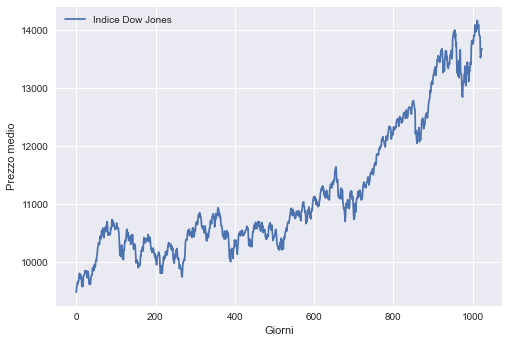

In [40]:
data=loadtxt("dow2.txt")

N=len(data)
tau=1
T=N*tau
time=linspace(0,T,N)

fig,ax = plt.subplots()
ax.plot(time,data, label="Indice Dow Jones")
ax.set_xlabel("Giorni")
ax.set_ylabel("Prezzo medio")
ax.legend()

F=Fourier(data,tau)

Text(0.5, 1.0, 'Trasformata di Fourier')

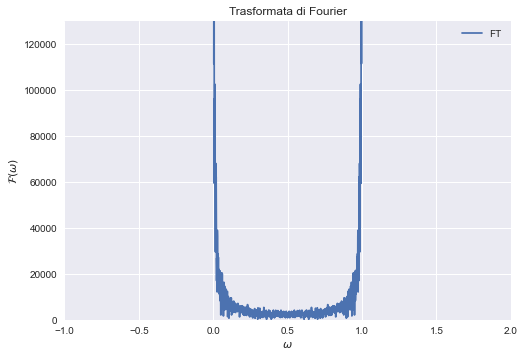

In [36]:
omega=arange(N)/T

fig1,ax1 = plt.subplots()
ax1.plot(omega, np.abs(F), label="FT")
ax1.set_xlabel("$\\omega$")
ax1.set_ylabel("$\mathcal{F}(\\omega)$")
ax1.set_xlim( left=-1, right=2)
ax1.set_ylim(bottom=0, top=1.3e5)
ax1.legend()
plt.title("Trasformata di Fourier")

Una volta graficata la FT, si calcola la trasformata che tiene conto solamente del primo 2% dell'array della trasformata stessa, infine viene chiamata la funzione per l'antitrasformata. 

In [37]:
#utilizzo solo il primo 2%
limit = int(0.02 * N)
new_F=np.zeros(N, dtype="complex")
for i in range(0, limit):
    new_F[i] = F[i]
InvF = InvFourier(new_F, tau)



Si confrontano quindi i dati inziali con l'antitrasformata calcolata attraverso il 2% della trasformata dei dati iniziali. 

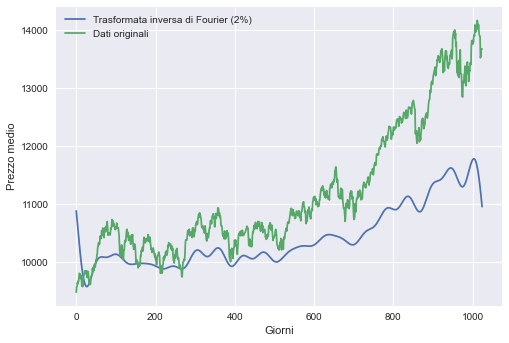

In [49]:
fig2,ax2 = plt.subplots()  
ax2.plot(time, np.abs(InvF)/1.1e3, label = "Trasformata inversa di Fourier (2%)")
ax2.plot(time,data, label="Dati originali")
ax2.set_xlabel("Giorni")
ax2.set_ylabel("Prezzo medio")
ax2.legend()

plt.show()

Come si evince dal grafico subito sopra, la trasformata inversa di Fourier dei dati precedentemente trasformati e utilizzati solo nel loro primo 2% vede una perdita di informazione tale da far assumere al segnale il comportamento graficato. 